수집일,내부-내부CO2,양액-(양액)공급EC,토양-토양EC,양액-(양액)배액EC,외부-외부습도,내부-내부습도,토양-지습,내부-광량,내부-내부일사량,양액-(양액)공급PH,토양-토양PH,양액-(양액)배액PH,외부-외부일사량,외부-외부온도,내부-내부온도,토양-지중온도

단체표준명,내부CO2,수경급액EC(양액 전기전도도),근권토양(배지)EC,수경배액EC(폐액 전기전도도),외부상대습도,내부습도,근권수분함량,내부광도,내부일사량,수경급액pH(양액산도),근권토양(배지)Ph,수경배액pH(폐액 산도),외부일사량,외부온도,내부온도,근권온도

Date_Time,InternalEnvironment_CarbonDioxide,WaterCultureEnvironment_NutrientSolutionElectricalConductivity,Root-zoneEnvironment_PlantationElectricalConductivity,WaterCultureEnvironment_DrainageElectricalConductivity,ExternalEnvironment_RelativeHumidity,InternalEnvironment_Humidity,Root-zoneEnvironment_MoistureContent,InternalEnvironment_Illuminance,InternalEnvironment_Insolation,WaterCultureEnvironment_NutrientSolutionAcidity,Root-zoneEnvironment_PlantationAcidity,WaterCultureEnvironment_DrainageAcidity,ExternalEnvironment_Insolation,ExternalEnvironment_Temperature,InternalEnvironment_Temperature,Root-zoneEnvironment_Temperature

In [95]:
# 1. 라이브러리 및 데이터 로드
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Try reading with a different encoding
try:
    df = pd.read_csv('./시설원예_환경정보_데이터.csv', encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv('./시설원예_환경정보_데이터.csv', encoding='cp949')

print(df.head())
print("컬럼:", df.columns)
print("결측치:\n", df.isnull().sum())


           Date_Time InternalEnvironment_CarbonDioxide  \
0  2023-10-12 150000                            239.00   
1  2023-10-12 160000                            238.00   
2  2023-10-12 170000                            234.00   
3  2023-10-12 180000                            250.00   
4  2023-10-12 190000                            273.00   

   WaterCultureEnvironment_NutrientSolutionElectricalConductivity  \
0                                                1.0                
1                                                1.0                
2                                                1.0                
3                                                1.0                
4                                                0.0                

  Root-zoneEnvironment_PlantationElectricalConductivity  \
0                                                         
1                                                         
2                                                         


In [96]:
# Date_Time 컬럼을 날짜와 시간으로 분리하여 숫자로 변환
import pandas as pd

# Date_Time 컬럼이 있는지 확인
if 'Date_Time' in df.columns:
    # print("Date_Time 컬럼 샘플 값:", df['Date_Time'].head())
    
    # '2023-10-12 150000' 형식 처리
    df['Date_Time'] = df['Date_Time'].astype(str)
    
    # 날짜와 시간 분리
    datetime_split = df['Date_Time'].str.split(' ', expand=True)
    
    # 날짜 부분 (2023-10-12) -> 숫자로 변환 (20231012)
    df['Date_Num'] = datetime_split[0].str.replace('-', '').astype(int)
    
    # 시간 부분 (150000) -> 숫자로 변환
    df['Time_Num'] = datetime_split[1].astype(int)
    
    # 추가적인 시간 특성 추출
    # df['Hour'] = (df['Time_Num'] // 10000).astype(int)  # 시간 (15)
    # df['Minute'] = ((df['Time_Num'] % 10000) // 100).astype(int)  # 분 (00)
    # df['Second'] = (df['Time_Num'] % 100).astype(int)  # 초 (00)
    
    # 원본 Date_Time 컬럼 삭제
    df = df.drop('Date_Time', axis=1)
    
    # print("변환 결과:")
    # print(f"Date_Num: {df['Date_Num'].head()}")
    # print(f"Time_Num: {df['Time_Num'].head()}")
    # print(f"Hour: {df['Hour'].head()}")
    # print(f"Minute: {df['Minute'].head()}")
    # print(f"Second: {df['Second'].head()}")

    # print(df.head())
    
else:
    print("Date_Time 컬럼을 찾을 수 없습니다.")
    print("사용 가능한 컬럼:", df.columns.tolist())

In [97]:

# 2. EDA 및 전처리

if 'InternalEnvironment_Illuminance' in df.columns:
    df = df.drop('InternalEnvironment_Illuminance', axis=1)

# (내부CO2 컬럼 자동 탐색)
candidates = [c for c in df.columns if 'power' in c.lower() or 'usage' in c.lower() or 'target' in c.lower()]
target_col = candidates[0] if candidates else num_cols[-1]
target_col = 'InternalEnvironment_CarbonDioxide'
print("예측 대상:", target_col)

df[target_col] = pd.to_numeric(df[target_col], errors='coerce').astype(float)

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
print("수치형:", num_cols)
print("범주형:", cat_cols)
for col in cat_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)

print("범주형2:", cat_cols)


예측 대상: InternalEnvironment_CarbonDioxide
수치형: ['InternalEnvironment_CarbonDioxide', 'WaterCultureEnvironment_NutrientSolutionElectricalConductivity', 'WaterCultureEnvironment_DrainageElectricalConductivity', 'InternalEnvironment_Humidity', 'InternalEnvironment_Insolation', 'WaterCultureEnvironment_NutrientSolutionAcidity', 'WaterCultureEnvironment_DrainageAcidity', 'Date_Num', 'Time_Num']
범주형: ['Root-zoneEnvironment_PlantationElectricalConductivity', 'ExternalEnvironment_RelativeHumidity', 'Root-zoneEnvironment_MoistureContent', 'Root-zoneEnvironment_PlantationAcidity', 'ExternalEnvironment_Insolation', 'ExternalEnvironment_Temperature', 'InternalEnvironment_Temperature', 'Root-zoneEnvironment_Temperature']
범주형2: ['Root-zoneEnvironment_PlantationElectricalConductivity', 'ExternalEnvironment_RelativeHumidity', 'Root-zoneEnvironment_MoistureContent', 'Root-zoneEnvironment_PlantationAcidity', 'ExternalEnvironment_Insolation', 'ExternalEnvironment_Temperature', 'InternalEnvironment_Tempera

In [98]:
# try:
#     df = pd.read_csv('./시설원예_환경정보_데이터.csv', encoding='utf-8')
# except UnicodeDecodeError:
#     df = pd.read_csv('./시설원예_환경정보_데이터.csv', encoding='cp949')

# if 'InternalEnvironment_Illuminance' in df.columns:
#     df = df.drop('InternalEnvironment_Illuminance', axis=1)

# # print(df.head())
# print("컬럼:", df.columns)
# print("결측치:\n", df.isnull().sum())


# 모든 컬럼의 결측치 개수
print(f" 총 결측치 {df.isnull().sum()}")
# target_col만 확인
print(f" target 결측치 {df[[target_col]].isnull().sum()}")


# 삭제할 행의 조건 정의
target_nan = df[target_col].isna()
other_cols_nan_count = df.drop(target_col, axis=1).isna().sum(axis=1)
rows_to_drop = target_nan & (other_cols_nan_count >= 3)

# 삭제 전 정보 출력
print(f"삭제 전 총 행 수: {len(df)}")
print(f"삭제할 행 수: {rows_to_drop.sum()}")

# 해당 행들 삭제
df = df[~rows_to_drop]

print(f"삭제 후 총 행 수: {len(df)}")
print(f"삭제된 행 수: {rows_to_drop.sum()}")


 총 결측치 InternalEnvironment_CarbonDioxide                                 459
WaterCultureEnvironment_NutrientSolutionElectricalConductivity      0
Root-zoneEnvironment_PlantationElectricalConductivity             247
WaterCultureEnvironment_DrainageElectricalConductivity              0
ExternalEnvironment_RelativeHumidity                               31
InternalEnvironment_Humidity                                        0
Root-zoneEnvironment_MoistureContent                              247
InternalEnvironment_Insolation                                      0
WaterCultureEnvironment_NutrientSolutionAcidity                     0
Root-zoneEnvironment_PlantationAcidity                            247
WaterCultureEnvironment_DrainageAcidity                             0
ExternalEnvironment_Insolation                                    247
ExternalEnvironment_Temperature                                    70
InternalEnvironment_Temperature                                   417
Root-zoneEnvi

In [99]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# 결측치 처리
for col in num_cols:
    df[col] = df[col].fillna(df[col].mean())
for col in cat_cols:    
    df[col] = df[col].fillna(df[col].mode()[0])


# 범주형 인코딩
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])



print(df.head())


   InternalEnvironment_CarbonDioxide  \
0                              239.0   
1                              238.0   
2                              234.0   
3                              250.0   
4                              273.0   

   WaterCultureEnvironment_NutrientSolutionElectricalConductivity  \
0                                                1.0                
1                                                1.0                
2                                                1.0                
3                                                1.0                
4                                                0.0                

   Root-zoneEnvironment_PlantationElectricalConductivity  \
0                                                0.0       
1                                                0.0       
2                                                0.0       
3                                                0.0       
4                                           

=== 정규화 전 데이터 통계 ===
Target 컬럼 (InternalEnvironment_CarbonDioxide) 통계:
count    4057.000000
mean      832.909091
std       879.885590
min       204.000000
25%       329.000000
50%       574.000000
75%       843.000000
max      5000.000000
Name: InternalEnvironment_CarbonDioxide, dtype: float64

정규화할 특성 컬럼 수: 16

=== 정규화 후 첫 번째 특성 컬럼 통계 비교 ===
원본 데이터 (WaterCultureEnvironment_NutrientSolutionElectricalConductivity):
count    4057.000000
mean        0.577274
std         0.503446
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         4.000000
Name: WaterCultureEnvironment_NutrientSolutionElectricalConductivity, dtype: float64

StandardScaler 적용 후:
count    4.057000e+03
mean    -1.541231e-16
std      1.000123e+00
min     -1.146787e+00
25%     -1.146787e+00
50%      8.397690e-01
75%      8.397690e-01
max      6.799436e+00
Name: WaterCultureEnvironment_NutrientSolutionElectricalConductivity, dtype: float64

MinMaxScaler 적용 후:
count    4057.000000
mean 

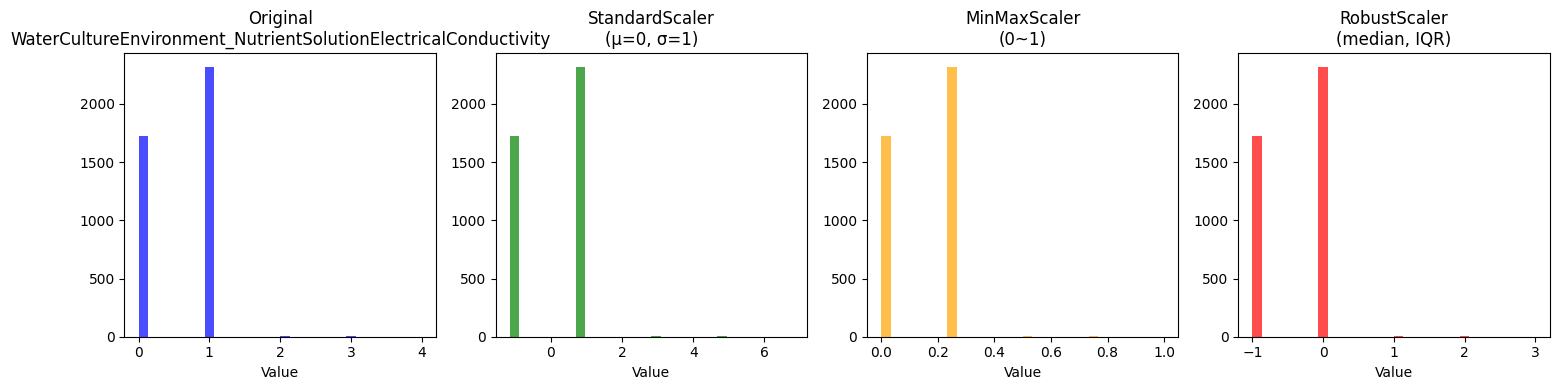


=== 정규화 방법 선택 ===
StandardScaler를 기본으로 사용합니다.
정규화 완료! 정규화된 데이터프레임: df_normalized
Shape: (4057, 17)

정규화 전후 상관관계 변화 (target과의 상관관계):
WaterCultureEnvironment_NutrientSolutionElectricalConductivity: -0.162 → -0.162
Root-zoneEnvironment_PlantationElectricalConductivity: nan → nan
WaterCultureEnvironment_DrainageElectricalConductivity: -0.257 → -0.257
ExternalEnvironment_RelativeHumidity: -0.179 → -0.179
InternalEnvironment_Humidity: 0.233 → 0.233


/Users/kwangsiklee/miniforge3/envs/llmenv/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/kwangsiklee/miniforge3/envs/llmenv/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [100]:
# 데이터 정규화 (Normalization/Standardization)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import numpy as np

print("=== 정규화 전 데이터 통계 ===")
print(f"Target 컬럼 ({target_col}) 통계:")
print(df[target_col].describe())

# 수치형 컬럼들 선택 (target 제외)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_cols:
    feature_cols = [col for col in numeric_cols if col != target_col]
else:
    feature_cols = numeric_cols

print(f"\n정규화할 특성 컬럼 수: {len(feature_cols)}")

# 1. StandardScaler (평균 0, 표준편차 1)
scaler_standard = StandardScaler()
df_standard = df.copy()
df_standard[feature_cols] = scaler_standard.fit_transform(df[feature_cols])

# 2. MinMaxScaler (0~1 범위)
scaler_minmax = MinMaxScaler()
df_minmax = df.copy()
df_minmax[feature_cols] = scaler_minmax.fit_transform(df[feature_cols])

# 3. RobustScaler (중앙값과 IQR 사용, 이상치에 강함)
scaler_robust = RobustScaler()
df_robust = df.copy()
df_robust[feature_cols] = scaler_robust.fit_transform(df[feature_cols])

# 정규화 결과 비교
print("\n=== 정규화 후 첫 번째 특성 컬럼 통계 비교 ===")
first_col = feature_cols[0]
print(f"원본 데이터 ({first_col}):")
print(df[first_col].describe())

print(f"\nStandardScaler 적용 후:")
print(df_standard[first_col].describe())

print(f"\nMinMaxScaler 적용 후:")
print(df_minmax[first_col].describe())

print(f"\nRobustScaler 적용 후:")
print(df_robust[first_col].describe())

# 시각화로 정규화 효과 확인
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))

# 원본 데이터
plt.subplot(1, 4, 1)
plt.hist(df[first_col].dropna(), bins=30, alpha=0.7, color='blue')
plt.title(f'Original\n{first_col}')
plt.xlabel('Value')

# StandardScaler
plt.subplot(1, 4, 2)
plt.hist(df_standard[first_col].dropna(), bins=30, alpha=0.7, color='green')
plt.title('StandardScaler\n(μ=0, σ=1)')
plt.xlabel('Value')

# MinMaxScaler
plt.subplot(1, 4, 3)
plt.hist(df_minmax[first_col].dropna(), bins=30, alpha=0.7, color='orange')
plt.title('MinMaxScaler\n(0~1)')
plt.xlabel('Value')

# RobustScaler
plt.subplot(1, 4, 4)
plt.hist(df_robust[first_col].dropna(), bins=30, alpha=0.7, color='red')
plt.title('RobustScaler\n(median, IQR)')
plt.xlabel('Value')

plt.tight_layout()
plt.show()

# 사용할 정규화 방법 선택 (StandardScaler를 기본으로)
print("\n=== 정규화 방법 선택 ===")
print("StandardScaler를 기본으로 사용합니다.")
df_normalized = df_standard.copy()

print(f"정규화 완료! 정규화된 데이터프레임: df_normalized")
print(f"Shape: {df_normalized.shape}")

# 정규화 전후 상관관계 확인
print(f"\n정규화 전후 상관관계 변화 (target과의 상관관계):")
for col in feature_cols[:5]:  # 처음 5개 특성만 확인
    corr_before = df[col].corr(df[target_col])
    corr_after = df_normalized[col].corr(df_normalized[target_col])
    print(f"{col}: {corr_before:.3f} → {corr_after:.3f}")

df = df_normalized

=== Target 컬럼 이상치 분석 및 처리 ===
Target 컬럼: InternalEnvironment_CarbonDioxide
원본 데이터 통계:
count    4057.000000
mean      832.909091
std       879.885590
min       204.000000
25%       329.000000
50%       574.000000
75%       843.000000
max      5000.000000
Name: InternalEnvironment_CarbonDioxide, dtype: float64

=== IQR 방법 이상치 탐지 ===
Q1 (25%): 329.00
Q3 (75%): 843.00
IQR: 514.00
하한선: -442.00
상한선: 1614.00
IQR 방법 이상치 개수: 424 (10.45%)

Z-Score 방법 이상치 개수 (|z| > 3): 137 (3.38%)
Modified Z-Score 방법 이상치 개수 (MAD > 3.5): 306 (7.54%)

95% 백분위수 (2656.40) 초과: 203개
99% 백분위수 (4551.52) 초과: 82개


/var/folders/xn/w4kqb1715fz7h49tp_h7hbmr0000gn/T/ipykernel_59383/2016968539.py:104: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/xn/w4kqb1715fz7h49tp_h7hbmr0000gn/T/ipykernel_59383/2016968539.py:104: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/xn/w4kqb1715fz7h49tp_h7hbmr0000gn/T/ipykernel_59383/2016968539.py:104: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/kwangsiklee/miniforge3/envs/llmenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kwangsiklee/miniforge3/envs/llmenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from font(s) DejaVu Sans.
  fig.can

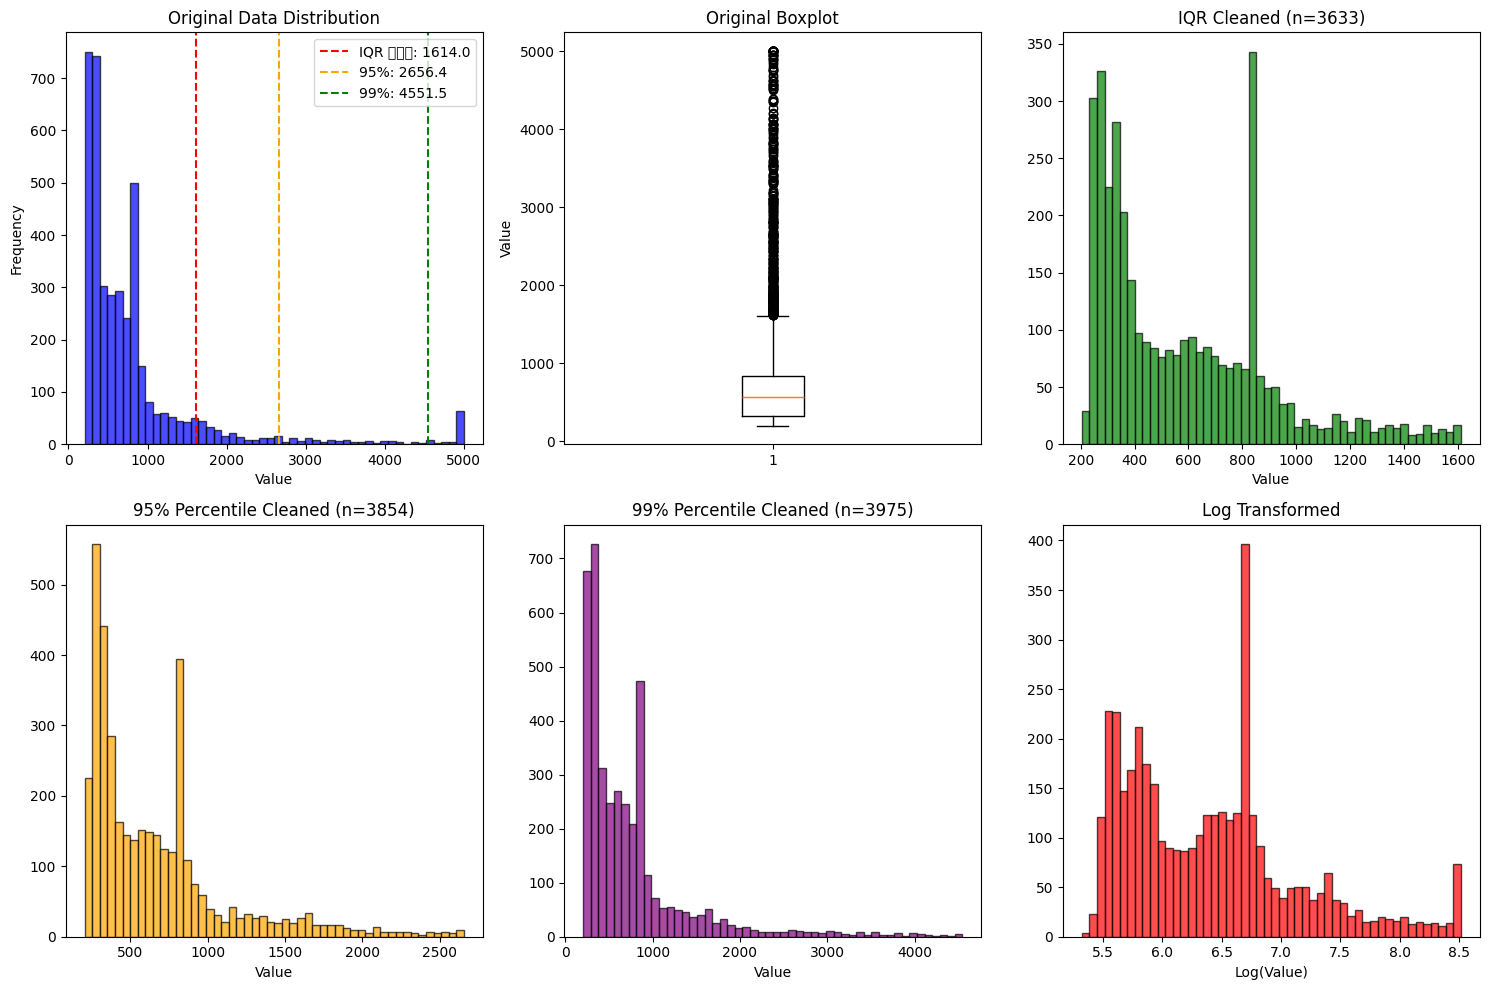


=== 이상치 처리 방법별 결과 비교 ===
원본 데이터: 4057행
IQR 방법 (1.5*IQR): 3633행 (제거: 424행)
95% 백분위수: 3854행 (제거: 203행)
99% 백분위수: 4057행 (제거: 0행)

=== 방법별 통계 비교 ===
Original:
  평균: 832.91, 표준편차: 879.89
  최솟값: 204.00, 최댓값: 5000.00
  왜도: 3.005
IQR_Cleaned:
  평균: 583.52, 표준편차: 315.98
  최솟값: 204.00, 최댓값: 1612.00
  왜도: 1.029
P95_Cleaned:
  평균: 663.65, 표준편차: 452.88
  최솟값: 204.00, 최댓값: 2656.00
  왜도: 1.736
P98_Cleaned:
  평균: 748.35, 표준편차: 660.29
  최솟값: 204.00, 최댓값: 4548.00
  왜도: 2.690

=== 권장사항 ===
1. 데이터 손실 최소화: 99% 백분위수 방법 (3975행 유지)
2. 이상치 엄격 제거: IQR 방법 (3633행 유지)
3. 로그 변환: 분포 정규화 효과

기본 선택: 99% 백분위수 방법
df_outlier_cleaned: 3975행


In [101]:
# Target 컬럼 이상치 처리
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

print("=== Target 컬럼 이상치 분석 및 처리 ===")
print(f"Target 컬럼: {target_col}")
print(f"원본 데이터 통계:")
print(df[target_col].describe())

# 1. IQR 방법으로 이상치 탐지
Q1 = df[target_col].quantile(0.25)
Q3 = df[target_col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"\n=== IQR 방법 이상치 탐지 ===")
print(f"Q1 (25%): {Q1:.2f}")
print(f"Q3 (75%): {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"하한선: {lower_bound:.2f}")
print(f"상한선: {upper_bound:.2f}")

# 이상치 개수 확인
outliers_iqr = df[(df[target_col] < lower_bound) | (df[target_col] > upper_bound)]
print(f"IQR 방법 이상치 개수: {len(outliers_iqr)} ({len(outliers_iqr)/len(df)*100:.2f}%)")

# 2. Z-Score 방법으로 이상치 탐지
z_threshold = 3
z_scores = np.abs(stats.zscore(df[target_col].dropna()))
outliers_zscore = df[target_col].dropna()[z_scores > z_threshold]
print(f"\nZ-Score 방법 이상치 개수 (|z| > {z_threshold}): {len(outliers_zscore)} ({len(outliers_zscore)/len(df)*100:.2f}%)")

# 3. Modified Z-Score 방법 (MAD 기반)
def modified_z_score(data):
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    modified_z_scores = 0.6745 * (data - median) / mad
    return modified_z_scores

mad_threshold = 3.5
mad_scores = np.abs(modified_z_score(df[target_col].dropna()))
outliers_mad = df[target_col].dropna()[mad_scores > mad_threshold]
print(f"Modified Z-Score 방법 이상치 개수 (MAD > {mad_threshold}): {len(outliers_mad)} ({len(outliers_mad)/len(df)*100:.2f}%)")

# 4. 백분위수 방법 (95%, 99% 기준)
p95 = df[target_col].quantile(0.95)
p98 = df[target_col].quantile(0.98)
outliers_p95 = df[df[target_col] > p95]
outliers_p98 = df[df[target_col] > p98]
print(f"\n95% 백분위수 ({p95:.2f}) 초과: {len(outliers_p95)}개")
print(f"99% 백분위수 ({p98:.2f}) 초과: {len(outliers_p98)}개")

# 시각화
plt.figure(figsize=(15, 10))

# 원본 데이터 히스토그램
plt.subplot(2, 3, 1)
plt.hist(df[target_col].dropna(), bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(upper_bound, color='red', linestyle='--', label=f'IQR 상한선: {upper_bound:.1f}')
plt.axvline(p95, color='orange', linestyle='--', label=f'95%: {p95:.1f}')
plt.axvline(p98, color='green', linestyle='--', label=f'99%: {p98:.1f}')
plt.title('Original Data Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# 박스플롯
plt.subplot(2, 3, 2)
plt.boxplot(df[target_col].dropna())
plt.title('Original Boxplot')
plt.ylabel('Value')

# IQR 방법으로 이상치 제거
df_iqr_cleaned = df[(df[target_col] >= lower_bound) & (df[target_col] <= upper_bound)]
plt.subplot(2, 3, 3)
plt.hist(df_iqr_cleaned[target_col], bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title(f'IQR Cleaned (n={len(df_iqr_cleaned)})')
plt.xlabel('Value')

# 95% 백분위수 방법으로 이상치 제거
df_p95_cleaned = df[df[target_col] <= p95]
plt.subplot(2, 3, 4)
plt.hist(df_p95_cleaned[target_col], bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.title(f'95% Percentile Cleaned (n={len(df_p95_cleaned)})')
plt.xlabel('Value')

# 98% 백분위수 방법으로 이상치 제거
df_p98_cleaned = df[df[target_col] <= p98]
plt.subplot(2, 3, 5)
plt.hist(df_p98_cleaned[target_col], bins=50, alpha=0.7, color='purple', edgecolor='black')
plt.title(f'99% Percentile Cleaned (n={len(df_p98_cleaned)})')
plt.xlabel('Value')

# 로그 변환
plt.subplot(2, 3, 6)
log_data = np.log1p(df[target_col].dropna())  # log1p = log(1+x), 0 처리 안전
plt.hist(log_data, bins=50, alpha=0.7, color='red', edgecolor='black')
plt.title('Log Transformed')
plt.xlabel('Log(Value)')

plt.tight_layout()
plt.show()

# 처리 방법별 결과 비교
print(f"\n=== 이상치 처리 방법별 결과 비교 ===")
print(f"원본 데이터: {len(df)}행")
print(f"IQR 방법 (1.5*IQR): {len(df_iqr_cleaned)}행 (제거: {len(df)-len(df_iqr_cleaned)}행)")
print(f"95% 백분위수: {len(df_p95_cleaned)}행 (제거: {len(df)-len(df_p95_cleaned)}행)")
print(f"99% 백분위수: {len(df_p99_cleaned)}행 (제거: {len(df)-len(df_p99_cleaned)}행)")

# 통계 비교
methods = {
    'Original': df[target_col],
    'IQR_Cleaned': df_iqr_cleaned[target_col],
    'P95_Cleaned': df_p95_cleaned[target_col],
    'P98_Cleaned': df_p98_cleaned[target_col]
}

print(f"\n=== 방법별 통계 비교 ===")
for name, data in methods.items():
    print(f"{name}:")
    print(f"  평균: {data.mean():.2f}, 표준편차: {data.std():.2f}")
    print(f"  최솟값: {data.min():.2f}, 최댓값: {data.max():.2f}")
    print(f"  왜도: {data.skew():.3f}")

# 권장 방법 선택
print(f"\n=== 권장사항 ===")
print(f"1. 데이터 손실 최소화: 99% 백분위수 방법 ({len(df_p98_cleaned)}행 유지)")
print(f"2. 이상치 엄격 제거: IQR 방법 ({len(df_iqr_cleaned)}행 유지)")
print(f"3. 로그 변환: 분포 정규화 효과")

# 최종 선택 (99% 백분위수 방법을 기본으로)
df_outlier_cleaned = df_p98_cleaned.copy()
print(f"\n기본 선택: 99% 백분위수 방법")
print(f"df_outlier_cleaned: {len(df_outlier_cleaned)}행")

df = df_outlier_cleaned

=== Target 컬럼 기본 통계 ===
count    3975.000000
mean      748.350234
std       660.286295
min       204.000000
25%       327.000000
50%       559.000000
75%       832.909091
max      4548.000000
Name: InternalEnvironment_CarbonDioxide, dtype: float64

결측치 개수: 0
유니크 값 개수: 1288


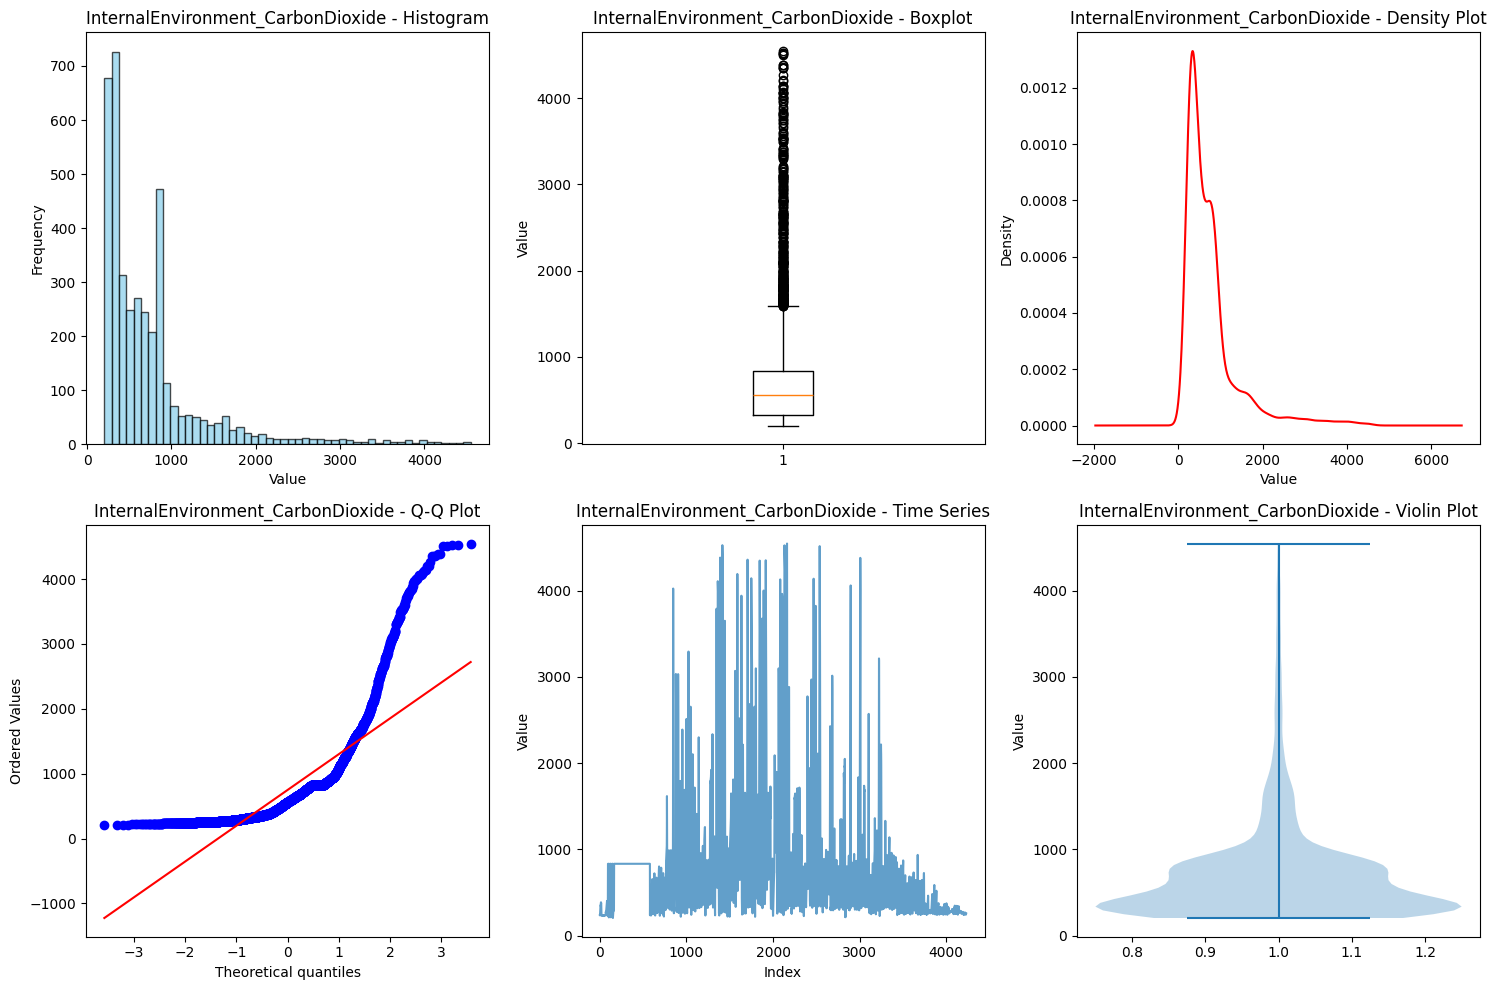


=== 분포 특성 ===
왜도(Skewness): 2.690
첨도(Kurtosis): 8.702
최솟값: 204.0
최댓값: 4548.0
범위: 4344.0


In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

# 기본 통계 정보
print("=== Target 컬럼 기본 통계 ===")
print(df[target_col].describe())
print(f"\n결측치 개수: {df[target_col].isnull().sum()}")
print(f"유니크 값 개수: {df[target_col].nunique()}")

# 시각화
plt.figure(figsize=(15, 10))

# 1. 히스토그램
plt.subplot(2, 3, 1)
plt.hist(df[target_col].dropna(), bins=50, alpha=0.7, color='skyblue',
edgecolor='black')
plt.title(f'{target_col} - Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')

# 2. 박스플롯
plt.subplot(2, 3, 2)
plt.boxplot(df[target_col].dropna())
plt.title(f'{target_col} - Boxplot')
plt.ylabel('Value')

# 3. 밀도 플롯
plt.subplot(2, 3, 3)
df[target_col].dropna().plot(kind='density', color='red')
plt.title(f'{target_col} - Density Plot')
plt.xlabel('Value')

# 4. Q-Q 플롯 (정규분포 확인)
from scipy import stats
plt.subplot(2, 3, 4)
stats.probplot(df[target_col].dropna(), dist="norm", plot=plt)
plt.title(f'{target_col} - Q-Q Plot')

# 5. 시계열 플롯 (인덱스별)
plt.subplot(2, 3, 5)
plt.plot(df[target_col], alpha=0.7)
plt.title(f'{target_col} - Time Series')
plt.xlabel('Index')
plt.ylabel('Value')

# 6. 바이올린 플롯
plt.subplot(2, 3, 6)
plt.violinplot([df[target_col].dropna()], positions=[1])
plt.title(f'{target_col} - Violin Plot')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

# 추가 분석
print("\n=== 분포 특성 ===")
print(f"왜도(Skewness): {df[target_col].skew():.3f}")
print(f"첨도(Kurtosis): {df[target_col].kurtosis():.3f}")
print(f"최솟값: {df[target_col].min()}")
print(f"최댓값: {df[target_col].max()}")
print(f"범위: {df[target_col].max() - df[target_col].min()}")

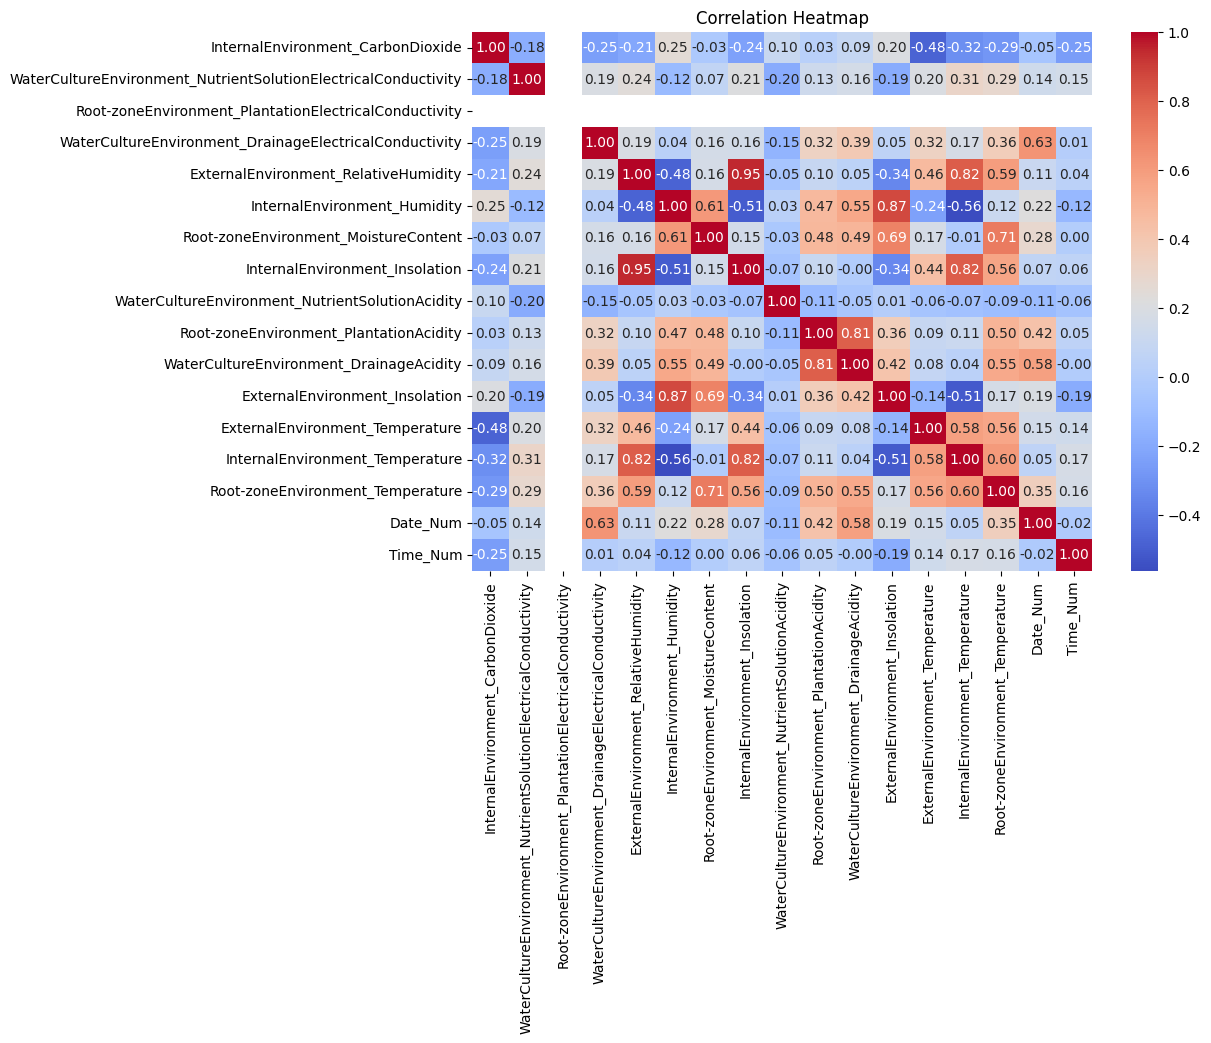

(3180, 16) (795, 16)
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[RF] Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[GBR] Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[XGB] Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}

--- [튜닝 후 모델별 성능] ---
RandomForest(Grid):
  MSE: 84304.70
  MAE: 136.30
  R2 : 0.8059
GradientBoosting(Grid):
  MSE: 78050.38
  MAE: 145.02
  R2 : 0.8203
XGBoost(Grid):
  MSE: 78051.77
  MAE: 144.52
  R2 : 0.8203
Ensemble(Voting, Grid):
  MSE: 75978.35
  MAE: 137.54
  R2 : 0.8250


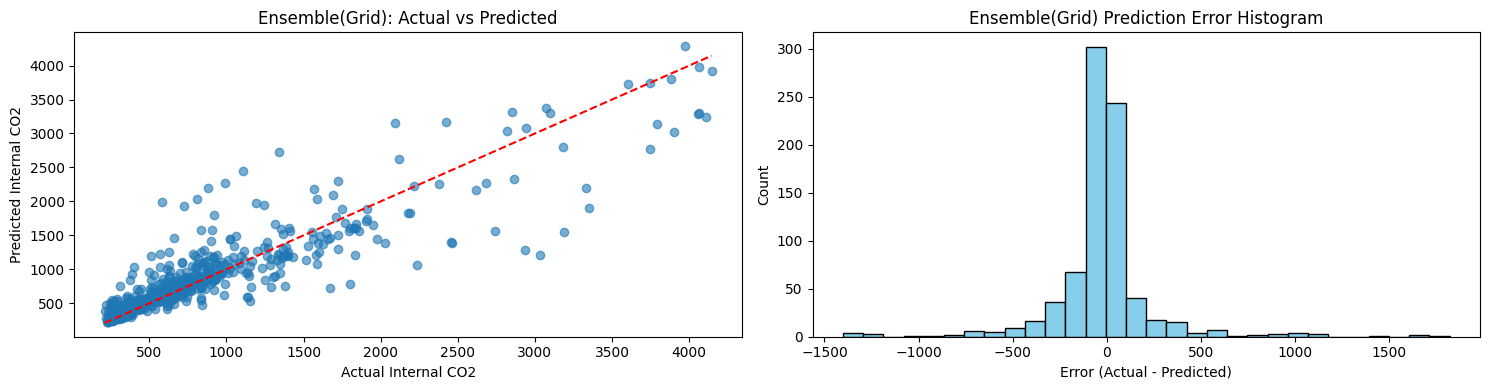

In [103]:

# 상관관계 히트맵
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# 3. train/test split
y = df[target_col]
X = df.drop([target_col], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(X_train.shape, X_test.shape)

# 4. 하이퍼파라미터 튜닝 (GridSearchCV)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
import xgboost as xgb

# RandomForest
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
)
rf_grid.fit(X_train, y_train)
print("[RF] Best params:", rf_grid.best_params_)

# GradientBoosting
gbr_params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}
gbr_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    gbr_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
)
gbr_grid.fit(X_train, y_train)
print("[GBR] Best params:", gbr_grid.best_params_)

# XGBoost
xgb_params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}
xgb_grid = GridSearchCV(
    xgb.XGBRegressor(random_state=42, tree_method='auto'),
    xgb_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
)
xgb_grid.fit(X_train, y_train)
print("[XGB] Best params:", xgb_grid.best_params_)

# 5. 앙상블 VotingRegressor (최적 모델로)
ensemble = VotingRegressor([
    ('rf', rf_grid.best_estimator_),
    ('gbr', gbr_grid.best_estimator_),
    ('xgb', xgb_grid.best_estimator_)
])
ensemble.fit(X_train, y_train)

# 6. 예측/평가/시각화
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def report(y_true, y_pred, name):
    print(f"{name}:")
    print(f"  MSE: {mean_squared_error(y_true, y_pred):.2f}")
    print(f"  MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"  R2 : {r2_score(y_true, y_pred):.4f}")

y_pred_ens = ensemble.predict(X_test)
y_pred_rf = rf_grid.best_estimator_.predict(X_test)
y_pred_gbr = gbr_grid.best_estimator_.predict(X_test)
y_pred_xgb = xgb_grid.best_estimator_.predict(X_test)

print("\n--- [튜닝 후 모델별 성능] ---")
report(y_test, y_pred_rf, "RandomForest(Grid)")
report(y_test, y_pred_gbr, "GradientBoosting(Grid)")
report(y_test, y_pred_xgb, "XGBoost(Grid)")
report(y_test, y_pred_ens, "Ensemble(Voting, Grid)")

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_ens, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Ensemble(Grid): Actual vs Predicted")
plt.xlabel("Actual Internal CO2")
plt.ylabel("Predicted Internal CO2")

plt.subplot(1,2,2)
plt.hist(y_test - y_pred_ens, bins=30, color='skyblue', edgecolor='k')
plt.title("Ensemble(Grid) Prediction Error Histogram")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
